In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quandl
import statistics
#import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense

# free data capture limits for some sources
# Get stock data from tiingo
# Ge treaury data from Quandl
import requests
nan=np.nan

In [266]:
DBGmode = 0
#st_date = '2020-7-1'
#en_date = '2020-9-11'
WritetoFile = 0

pd.set_option('display.max_rows', 15)
ticker = 'QQQ'
st_date = '2019-9-17'
en_date = '2020-9-16'

timestep = 3
TrainPCT = 0.85

ADDUS10Y = 1

ADDXMA = 0
xmasmall = 7
xmalong = 14

ADDRSI = 1
RSIwindow = 14

epochval = 100
batchval = 10

In [267]:
us10y_data = quandl.get("FRED/DGS10", start_date=st_date, end_date=en_date, api_key = 'tNjFxT5wYAG7nbemafxi')
us10y_data=us10y_data.reset_index()
us10y_data.rename(columns = {'Value':'US10Y'}, inplace = True) 

if DBGmode==1:
    us10y_data

In [268]:
for row in range(0,len(us10y_data)):
    us10y_data['Date'][row]=str(us10y_data['Date'][row])[:10]+'T00:00:00.000Z'
us10y_data=us10y_data.set_index('Date')

if DBGmode==1:
    us10y_data

<ipython-input-268-83275a74f87b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us10y_data['Date'][row]=str(us10y_data['Date'][row])[:10]+'T00:00:00.000Z'
/Users/prasannaob/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [269]:
def get_stock_data(stock_symbol, start_date, end_date):
    base_url = f'https://api.tiingo.com/tiingo/daily/{stock_symbol}/prices?'
    token = '59e2dfca5859e44a55ef766a8f81aab1ab8a80e8'
    payload = {
        'startDate': start_date,
        'endDate': end_date,
        'token': token
    }
    response = requests.get(base_url, params=payload)
    return response

In [270]:
response = get_stock_data(ticker, st_date, en_date)

if DBGmode == 1:
    print(response.url)
    print(response.json())

In [271]:
def parse_data(data_response):
    json_data = data_response.json()
    dates = []
    closes =[]
    opens = []
    highs = []
    lows = []
    vols = []
    for json_object in json_data:
        dates.append(json_object['date'])
        closes.append(json_object['close'])
        opens.append(json_object['open'])
        highs.append(json_object['high'])
        lows.append(json_object['low'])
        vols.append(json_object['volume'])
    return dates, closes, opens, highs, lows, vols

In [272]:
dates, closes, opens, highs, lows, vols = parse_data(response)

if DBGmode == 1:
    print(dates, closes)

In [273]:
#**** Define New Column Label here
datastock = pd.DataFrame(columns = ['Close'], index = dates)
dfindex = datastock.index
dfindex.name = 'Date'

In [274]:
#**** ADD New Column Data here
datastock['Close']=closes
#datastock['Volume']=vols

if DBGmode == 1:
    datastock

In [275]:
if DBGmode == 1:
    plt.plot(datastock['Close'], label=ticker+' Closes')
    plt.legend()
    plt.show()

In [276]:
print('Total Stock Rows = ', len(datastock))
print('Total US10Y Rows = ', len(us10y_data))

if ADDUS10Y==1:
    #****APPEND US10Y data here to a separate column in a new dataframe
    data=pd.concat([datastock, us10y_data], axis=1, sort=False)

    #fill US10Y NaN with previous value
    data['US10Y'].fillna(method='ffill', inplace=True)

else:
    data=datastock
    
data

Total Stock Rows =  253
Total US10Y Rows =  251


,Close,US10Y
2019-09-17T00:00:00.000Z,192.60,1.81
2019-09-18T00:00:00.000Z,192.52,1.80
2019-09-19T00:00:00.000Z,192.84,1.79
2019-09-20T00:00:00.000Z,190.80,1.74
2019-09-23T00:00:00.000Z,190.50,1.72
...,...,...
2020-09-10T00:00:00.000Z,272.34,0.68
2020-09-11T00:00:00.000Z,270.45,0.67
2020-09-14T00:00:00.000Z,275.16,0.68
2020-09-15T00:00:00.000Z,279.06,0.68


In [277]:
#Add XMA here

if ADDXMA == 1:
    #Enter SMA Data - defined at the top
    #xmasmall=5
    #xmalong=9
    #data['Close-XMA5'] = data.iloc[:,0].rolling(window=smasmall).mean()
    #data['Close-XMA9'] = data.iloc[:,0].rolling(window=smalong).mean()

    #Enter EMA Data - defined at the top
    #xmasmall=7
    #xmalong=14
    data['Close-XMA'+str(xmasmall)] = data.iloc[:,0].ewm(span=xmasmall, adjust=False).mean()
    data['Close-XMA'+str(xmalong)] = data.iloc[:,0].ewm(span=xmalong, adjust=False).mean()

    droprow=xmalong
    data.drop(data.index[0:droprow], inplace = True)

In [278]:
def computeRSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [279]:
#Add RSI here
if ADDRSI == 1:
    data['Close-RSI'+str(RSIwindow)] = computeRSI(data['Close'], RSIwindow)
    data.drop(data.index[0:RSIwindow], inplace = True)

In [280]:
data_noofcols = len(data.columns)
print('Number of data columns = ', data_noofcols)

Number of data columns =  3


In [281]:
data

,Close,US10Y,Close-RSI14
2019-10-07T00:00:00.000Z,188.24,1.56,44.227308
2019-10-08T00:00:00.000Z,185.42,1.54,36.943673
2019-10-09T00:00:00.000Z,187.23,1.59,43.388037
2019-10-10T00:00:00.000Z,188.68,1.67,47.975119
2019-10-11T00:00:00.000Z,191.11,1.76,54.612378
...,...,...,...
2020-09-10T00:00:00.000Z,272.34,0.68,44.499782
2020-09-11T00:00:00.000Z,270.45,0.67,43.178689
2020-09-14T00:00:00.000Z,275.16,0.68,47.371813
2020-09-15T00:00:00.000Z,279.06,0.68,50.621158


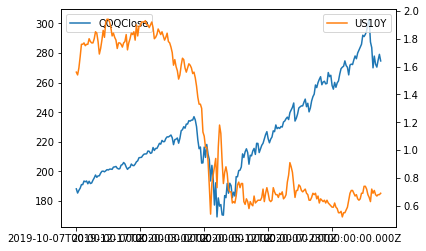

In [282]:
plt.figure()
data['Close'].plot(label=ticker+'Close')
if ADDXMA==1:
    data['Close-XMA'+str(xmasmall)].plot(label=ticker+'EMA'+str(xmasmall))
    data['Close-XMA'+str(xmalong)].plot(label=ticker+'EMA'+str(xmalong))
plt.legend()
if ADDUS10Y==1:
    data['US10Y'].plot(secondary_y=True, label='US10Y')
plt.legend()
#plt.plot(data['Close'], label=ticker+' Closes')
#plt.plot(data['US10Y'], label='US10Y')
plt.show()

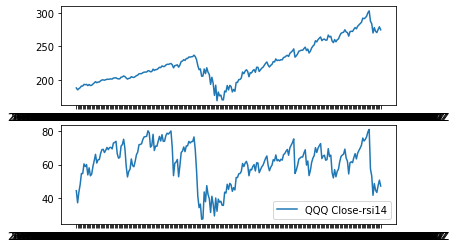

In [283]:
fig, axs = plt.subplots(2,1)
axs[0].plot(data['Close'], label=ticker+' Closes')
if ADDXMA==1:
    axs[0].plot(data['Close-XMA'+str(xmasmall)], label=ticker+' Close-ema'+str(xmasmall))
    axs[0].plot(data['Close-XMA'+str(xmalong)], label=ticker+' Close-ema'+str(xmalong))
    plt.legend()
if ADDRSI==1:
    axs[1].plot(data['Close-RSI'+str(RSIwindow)], label=ticker+' Close-rsi'+str(RSIwindow))
    plt.legend()
plt.show()

In [284]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

print('Length of scaled_data = ', len(scaled_data))
print(scaled_data)

Length of scaled_data =  239
[[0.14191518 0.73239437 0.31817704]
 [0.12078525 0.71830986 0.18384583]
 [0.13434737 0.75352113 0.30269845]
 [0.14521205 0.80985915 0.38729747]
 [0.16341975 0.87323944 0.50970763]
 [0.16326989 0.87323944 0.50856997]
 [0.1814776  0.88028169 0.6165015 ]
 [0.17788101 0.86619718 0.58680108]
 [0.18170238 0.87323944 0.60929909]
 [0.16776562 0.87323944 0.49401565]
 [0.18050352 0.90140845 0.57331376]
 [0.16896448 0.88732394 0.48425228]
 [0.17173685 0.88028169 0.50242291]
 [0.18574854 0.88028169 0.58927991]
 [0.19736251 0.90140845 0.6529865 ]
 [0.21182377 0.93661972 0.7232995 ]
 [0.20035966 0.92957746 0.62608583]
 [0.2074779  0.88732394 0.66252122]
 [0.20815226 0.82394366 0.66603247]
 [0.22156451 0.85211268 0.73344426]
 [0.23078076 0.8943662  0.77532096]
 [0.23160498 0.94366197 0.77905419]
 [0.22823318 0.9084507  0.74334194]
 [0.23325341 0.98591549 0.76924821]
 [0.23924771 1.         0.79946246]
 [0.23722464 1.         0.77526123]
 [0.24157051 0.98591549 0.79891167]

In [285]:
train_length = int(len(scaled_data) * TrainPCT)
test_length = len(scaled_data) - train_length
train_data = scaled_data[0:train_length,:]
test_data = scaled_data[train_length:len(scaled_data),:]

if DBGmode == 1:
    print('scaled_data length =', len(scaled_data))
    print('train_length = ', train_length)
    print('test_length = ', test_length)
    print(train_data)
    print(test_data)

In [286]:
def create_dataset(dataset, noofcols, timestep=1):
    data_x, data_y = [], []
    #for i in range(len(dataset) - timestep - 1):
        #data_x.append(dataset[i:(i+timestep),0])
        #data_y.append(dataset[i+timestep,0])
    for i in range(len(dataset) - timestep):
        data_x.append(dataset[i:(i+timestep),0:noofcols])
        data_y.append(dataset[i+timestep,0])
    #It has been shown that Numpy arrays need 4 times less memory compared to Python lists
    return np.array(data_x), np.array(data_y)

In [287]:
train_x, train_y = create_dataset(train_data, data_noofcols, timestep)
test_x, test_y = create_dataset(test_data, data_noofcols, timestep)

if DBGmode == 1:
    print(train_x)

In [288]:
if DBGmode == 1:
    print(train_y)

In [289]:
print('train_x shape = ', train_x.shape)
print('test_x shape = ', test_x.shape)
print('train_y shape = ', train_y.shape)
print('test_y shape = ', test_y.shape)

train_x shape =  (200, 3, 3)
test_x shape =  (33, 3, 3)
train_y shape =  (200,)
test_y shape =  (33,)


In [290]:
#train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[data_noofcols]))
#test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[data_noofcols]))

#Minimum 2
#train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[2]))
#test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[2]))

if DBGmode == 1:
    print(train_x)

In [291]:
#optimizer = 'adam' 'SGD' 'RMSprop' 'adadelta' 'adagrad' 'adamax' 'nadam' 'ftrl'
#activation = 'sigmoid' 'linear' relu' 'softmax' 'softplus' 'softsign' 'tanh' selu' 'elu' 'exponential' 
#loss = 'binary_crossentropy' 'mean_squared_error'

model = Sequential()
#model.add(LSTM(256, input_shape=(1,data_noofcols)))
model.add(LSTM(256, input_shape=(timestep,data_noofcols)))
model.add(Dense(1, activation='sigmoid'))
#model.add(Dense(6, input_dim=6, activation='relu'))
#model.add(Dense(6, activation='relu'))
#model.add(Dense(1, activation=None))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 256)               266240    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 266,497
Trainable params: 266,497
Non-trainable params: 0
_________________________________________________________________
None


In [292]:
model.fit(train_x, train_y, epochs=epochval, batch_size=batchval, verbose=1)
score = model.evaluate(train_x, train_y, verbose=0)
print('Keras model loss = ', score[0])
print('Keras model accuracy = ', score[1])

Epoch 1/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0291 - accuracy: 0.0050
Epoch 2/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0198 - accuracy: 0.0050
Epoch 3/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0136 - accuracy: 0.0050
Epoch 4/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0076 - accuracy: 0.0050
Epoch 5/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 0.0050
Epoch 6/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0024 - accuracy: 0.0050
Epoch 7/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 0.0050    
Epoch 8/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 0.0050
Epoch 9/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 0.0050
Epoch 10/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0019 - accuracy: 0.0050
Epoch

20/20 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.0050
Epoch 82/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.0050
Epoch 83/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.0050
Epoch 84/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.0050    
Epoch 85/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.0050
Epoch 86/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.0050    
Epoch 87/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.0050
Epoch 88/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0012 - accuracy: 0.0050    
Epoch 89/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.0050    
Epoch 90/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.00

In [293]:
train_predictions = model.predict(train_x)
test_predictions = model.predict(test_x)

if DBGmode == 1:
    print(train_predictions)

In [294]:
# create empty table with data_noofcols fields
train_predictions_like = np.zeros(shape=(len(train_predictions), data_noofcols) )
# put the predicted values in the right field
train_predictions_like[:,0] = train_predictions[:,0]
# inverse transform and then select the right field
train_predictions = scaler.inverse_transform(train_predictions_like)[:,0]

# create empty table with 2 fields
test_predictions_like = np.zeros(shape=(len(test_predictions), data_noofcols) )
# put the predicted values in the right field
test_predictions_like[:,0] = test_predictions[:,0]
# inverse transform and then select the right field
test_predictions = scaler.inverse_transform(test_predictions_like)[:,0]

In [295]:
if DBGmode == 1:
    print(train_predictions)
    print(test_predictions)

In [296]:
#train_predict_plot = np.empty_like(scaled_data[:,0])
train_predict_plot = scaled_data[:,0]
train_predict_plot[:] = np.nan
train_predict_plot[timestep:len(train_predictions)+timestep] = train_predictions

In [297]:
if DBGmode==1:
    print(test_predictions)

In [298]:
test_predict_plot = np.empty_like(scaled_data[:,0])
test_predict_plot[:] = np.nan
test_predict_plot[
    len(train_predictions)+timestep+timestep:len(scaled_data)] = test_predictions

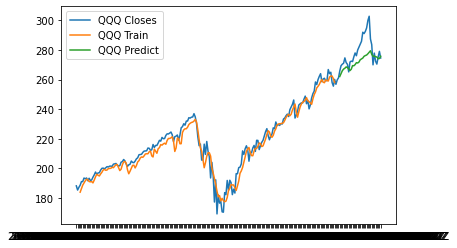

In [299]:
plt.plot(data.Close, label = ticker+' Closes')
plt.plot(train_predict_plot, label = ticker+' Train')
plt.plot(test_predict_plot, label = ticker+' Predict')
plt.legend()
plt.show()

In [300]:
print('Number of data[Close] rows = ', len(data['Close']))
print('Length of Train data = ', len(train_predictions))
print('Length of test data = ', len(test_predictions))

Number of data[Close] rows =  239
Length of Train data =  200
Length of test data =  33


In [301]:
data['AITrain'] = train_predict_plot
data['AITest'] = test_predict_plot
data

,Close,US10Y,Close-RSI14,AITrain,AITest
2019-10-07T00:00:00.000Z,188.24,1.56,44.227308,NaN,NaN
2019-10-08T00:00:00.000Z,185.42,1.54,36.943673,NaN,NaN
2019-10-09T00:00:00.000Z,187.23,1.59,43.388037,NaN,NaN
2019-10-10T00:00:00.000Z,188.68,1.67,47.975119,183.977130,NaN
2019-10-11T00:00:00.000Z,191.11,1.76,54.612378,186.255673,NaN
...,...,...,...,...,...
2020-09-10T00:00:00.000Z,272.34,0.68,44.499782,NaN,275.418274
2020-09-11T00:00:00.000Z,270.45,0.67,43.178689,NaN,275.257992
2020-09-14T00:00:00.000Z,275.16,0.68,47.371813,NaN,274.100508
2020-09-15T00:00:00.000Z,279.06,0.68,50.621158,NaN,274.205130


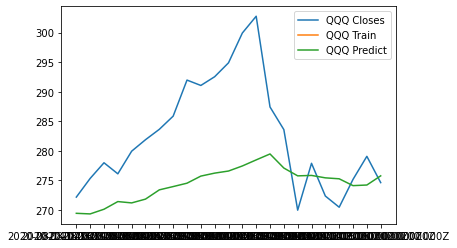

In [302]:
plt.plot(data.Close[-timestep-20:], label = ticker+' Closes')
plt.plot(train_predict_plot[-timestep-20:], label = ticker+' Train')
plt.plot(test_predict_plot[-timestep-20:], label = ticker+' Predict')
plt.legend()
plt.show()

In [303]:
data['Abs%Err']=nan
data['DirErr']=nan

In [304]:
#-----STOCK PRICE PREDICTION METRIC-----
for i in range(len(train_predictions)+timestep+timestep,len(scaled_data)):
    data['Abs%Err'][i]=100*(data['AITest'][i]-data['Close'][i])/data['Close'][i]

#-----DIRECTION PREDICTION METRIC-----
for i in range(len(train_predictions)+timestep+timestep+1,len(scaled_data)):
    parity=0
    if ((data['Close'][i] - data['Close'][i-1])*(data['AITest'][i] - data['AITest'][i-1])) > 0:
        data['DirErr'][i]=0
        parity=1
    if parity==0:
        data['DirErr'][i]=1

if DBGmode==1:
    print('Train length = ', len(train_predictions)+timestep)
    print('Total length = ', len(scaled_data))
    ch=len(train_predictions)+timestep+timestep+1
    print('data[Close][i]   = ', data['Close'][ch])
    print('data[Close][i-1] = ', data['Close'][ch-1])
    print('data[AITest][i]= ', data['AITest'][ch])
    print('data[AITest][i-1]= ', data['AITest'][ch-1])
    print('data[DirErr][i]  = ', data['DirErr'][ch])

In [305]:
if DBGmode==1:
    print(data['DirErr'][len(train_predictions)+timestep+timestep+1:len(scaled_data)])
    print(data['Abs%Err'][len(train_predictions)+timestep+timestep:len(scaled_data)])

In [306]:
Tot_test_error = sum(data['DirErr'][len(train_predictions)+timestep+timestep+1:len(scaled_data)])
Tot_test_len = sum(data['DirErr'].notnull())
Test_DirAcc = 100*(Tot_test_len - Tot_test_error) / Tot_test_len
print('timestep=', timestep)
print('')
print('----DIRECTION-----')
print('Total Test Errors = ', Tot_test_error)
print('Total Test Elements = ', Tot_test_len)
print('Test Direction Predict Accuracy = ', Test_DirAcc)
print('')
print('----STOCK PRICE PREDICTION-----')
len(train_predictions)+timestep,len(scaled_data)-timestep
print('Max % Price Error = ', max(data['Abs%Err'][len(train_predictions)+timestep+timestep:len(scaled_data)]))
print('Min % Price Error = ', min(data['Abs%Err'][len(train_predictions)+timestep+timestep:len(scaled_data)]))
print('Average % Price Error = ', statistics.mean(data['Abs%Err'][len(train_predictions)+timestep+timestep:len(scaled_data)]))

timestep= 3

----DIRECTION-----
Total Test Errors =  10.0
Total Test Elements =  32
Test Direction Predict Accuracy =  68.75

----STOCK PRICE PREDICTION-----
Max % Price Error =  2.150664418731538
Min % Price Error =  -8.02781827927959
Average % Price Error =  -2.3468813681907283


In [307]:
if WritetoFile == 1:
    data.to_csv(ticker+'_predict.csv')
    print('Wrote to file')

In [308]:
if DBGmode == 0:
    pd.set_option('display.max_rows', data.shape[0]+1)
    data

print('timestep=', timestep)
data.tail(timestep+10)

timestep= 3


,Close,US10Y,Close-RSI14,AITrain,AITest,Abs%Err,DirErr
2020-08-28T00:00:00.000Z,292.53,0.74,75.238902,NaN,276.217775,-5.576257,0.0
2020-08-31T00:00:00.000Z,294.88,0.72,76.799255,NaN,276.572458,-6.208472,0.0
2020-09-01T00:00:00.000Z,299.92,0.68,79.746998,NaN,277.428955,-7.499015,0.0
2020-09-02T00:00:00.000Z,302.76,0.66,81.196748,NaN,278.454977,-8.027818,0.0
2020-09-03T00:00:00.000Z,287.41,0.63,57.315752,NaN,279.460031,-2.766072,1.0
2020-09-04T00:00:00.000Z,283.58,0.72,53.117876,NaN,277.077963,-2.292840,0.0
2020-09-08T00:00:00.000Z,269.95,0.69,41.475765,NaN,275.755719,2.150664,0.0
2020-09-09T00:00:00.000Z,277.88,0.71,48.542256,NaN,275.827256,-0.738716,0.0
2020-09-10T00:00:00.000Z,272.34,0.68,44.499782,NaN,275.418274,1.130306,0.0
2020-09-11T00:00:00.000Z,270.45,0.67,43.178689,NaN,275.257992,1.777775,0.0
